# Geospatial Validation

@roman 

22 June, 2023

Code to remove inconsistent data from geospatial data.


---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import uuid
import os

from INEGIpy import MarcoGeoestadistico
from scipy.spatial.distance import pdist, squareform


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s1.parquet")

# original columns
original_columns = gdf_properties.columns

# to geodataframe
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs='EPSG:4326'
    )

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 956699 entries, 0 to 956698
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   valor_fisico_construccion      956699 non-null  float64       
 1   property_id                      956699 non-null  object        
 2   valuation_date                   956699 non-null  datetime64[ns]
 3   colonia                        956699 non-null  object        
 4   id_clase_inmueble              956699 non-null  int64         
 5   id_tipo_inmueble               956699 non-null  int64         
 6   conservacion                   956699 non-null  float64       
 7   elevador                       924417 non-null  float64       
 8   niveles                        956699 non-null  int64         
 9   cve_ref_proximidad_urbana      956699 non-null  int64         
 10  cve_nivel_equipamiento_urbano  956699 non-null  int64   

In [4]:
# sample (for prototyping)
# gdf_properties = gdf_properties.sample(10000)

In [5]:
# see original cols
original_columns

Index(['valor_fisico_construccion', 'property_id', 'valuation_date', 'colonia',
       'id_clase_inmueble', 'id_tipo_inmueble', 'conservacion', 'elevador',
       'niveles', 'cve_ref_proximidad_urbana', 'cve_nivel_equipamiento_urbano',
       'valor_mercado', 'valor_concluido_total', 'nivel', 'unidades_rentables',
       'edad_anios', 'precio_m2', 'vida_util_remanente',
       'cve_clasificacion_zona', 'cve_vigilancia', 'regimen_propiedad',
       'tipo_vialidad', 'id_uv', 'municipality_id', 'state_id',
       'clave_controlador', 'clave_valuador', 'id_otorgante', 'cp', 'latitude',
       'longitude', 'recamaras', 'banos', 'medio_banos', 'estacionamiento',
       'superficie_terreno', 'superficie_construida', 'superficie_accesoria',
       'superficie_vendible', 'valor_fisico_terreno_m2'],
      dtype='object')

## States

In [6]:
# get all mexico states
gdf_mex_states = geo_framework.Entidades()
gdf_mex_states.head()

,geometry,cvegeo,cve_agee,nom_agee,nom_abrev,pob,pob_fem,pob_mas,viv
0,"MULTIPOLYGON (((-102.29739 22.45527, -102.2955...",01,01,Aguascalientes,Ags.,1425607,728924,696683,386671
1,"MULTIPOLYGON (((-114.11561 28.09639, -114.1152...",02,02,Baja California,BC,3769020,1868431,1900589,1149563
2,"MULTIPOLYGON (((-109.89451 22.87476, -109.8946...",03,03,Baja California Sur,BCS,798447,392568,405879,240660
3,"MULTIPOLYGON (((-91.95650 20.19700, -91.95636 ...",04,04,Campeche,Camp.,928363,471424,456939,260824
4,"MULTIPOLYGON (((-102.31549 29.88000, -102.3150...",05,05,Coahuila de Zaragoza,Coah.,3146771,1583102,1563669,901249


<Axes: >

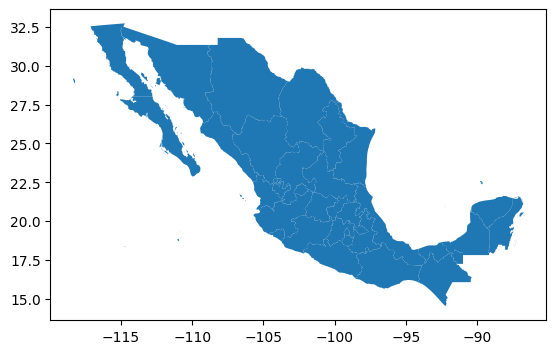

In [7]:
# plot states
gdf_mex_states.plot()

---
# Geospatial Validation

## S1: Points Inside Mexico

### Modify Data

In [8]:
# geodataframe
gdf_properties = (
    gdf_properties
    .assign(
        # in order to be aligned with the INEGI geo framework
        state_id=lambda x: x['state_id'].astype(str).str.zfill(2),
        municipality_id=lambda x: x['municipality_id'].astype(str).str.zfill(3)
    )
)

gdf_properties.loc[:, ['state_id', 'municipality_id']].head()

,state_id,municipality_id
0,07,027
1,07,107
2,03,008
3,09,003
4,21,051


### Spatial Join

In [9]:
# join properties with states, if the point is inside any state
gdf_properties_country_not_match = (
    gpd.sjoin(gdf_properties, gdf_mex_states, predicate='within', how='left')
    # get only the properties that did not match
    .loc[lambda x: x['cvegeo'].isna()]
    )

# print
print(f"Properties that did not match: {gdf_properties_country_not_match.shape[0]}")
print(f"Percentage of properties that did not match: {gdf_properties_country_not_match.shape[0] / gdf_properties.shape[0]}")

Properties that did not match: 24
Percentage of properties that did not match: 2.508626015078933e-05


<Axes: >

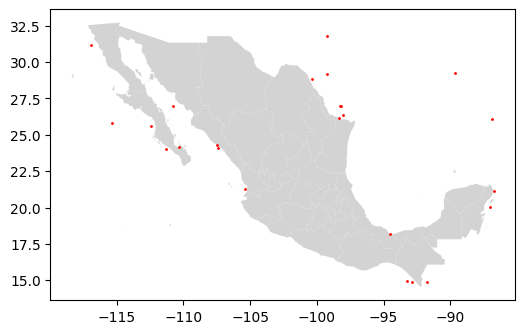

In [10]:
# plot properties that did not match
fig, ax = plt.subplots(figsize=(6, 6))
gdf_mex_states.plot(ax=ax, color='lightgrey')
gdf_properties_country_not_match.plot(ax=ax, color='red', markersize=1)

In [11]:
# clean the properties that did not match
gdf_properties = (
    gdf_properties
    .sjoin(gdf_mex_states, predicate='within', how='inner')
    .drop(columns=['index_right'])
    .loc[:, gdf_properties.columns]
)

In [12]:
# shape
gdf_properties.shape

(956675, 41)

## S2: Points inside each state 

In [13]:
# join properties with states, if the point is inside any state
gdf_properties_states_not_match = (
    gpd.sjoin(gdf_properties, gdf_mex_states, predicate='within', how='inner')
    .assign(state_id=lambda x: x['state_id'].astype(str).str.zfill(2))
    .query("state_id != cvegeo")
    )

print(f"Properties that did not match: {gdf_properties_states_not_match.shape[0]}")
print(f"Percentage of properties that did not match: {gdf_properties_states_not_match.shape[0] / gdf_properties.shape[0]}")

Properties that did not match: 187
Percentage of properties that did not match: 0.00019546868058640605


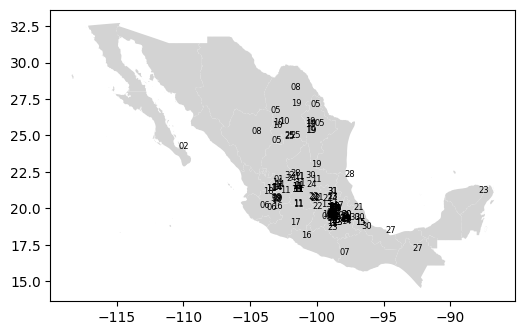

In [14]:
# plot properties that did not match
fig, ax = plt.subplots(figsize=(6, 6))
gdf_mex_states.plot(ax=ax, color='lightgrey')

# plot
for idx, row in gdf_properties_states_not_match.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row['state_id'], fontsize=6)

In [15]:
# clean the properties that did not match
gdf_properties = (
    gpd.sjoin(gdf_properties, gdf_mex_states, predicate='within', how='inner')
    .query("state_id == cvegeo")
    .drop(columns=['index_right'])
    .loc[:, gdf_properties.columns]
)
# print
gdf_properties.shape

(956488, 41)

## S3: Points inside each municipality

In [16]:
def process_id_entidad(id_entidad, gdf_properties):
    """
    Process the GeoDataFrame for a given id_entidad and save the result.

    Parameters:
    - id_entidad (str): The id_entidad to process.
    - gdf_properties (GeoDataFrame): The GeoDataFrame of properties.
    """
    # Get municipalities of the state
    gdf_mun = geo_framework.Municipios(id_entidad)

    # Filter and join GeoDataFrames
    gdf_result = (
        gdf_properties
        .query("state_id == @id_entidad")
        .sjoin(gdf_mun, how='left', predicate='within')
        .query("municipality_id != cve_agem")
    )

    return gdf_result

# process
entity_list = gdf_properties['state_id'].unique()
wrong_mun_gdf = []

for entity in tqdm(entity_list):
    wrong_mun_gdf.append(process_id_entidad(entity, gdf_properties))


100%|██████████| 32/32 [00:57<00:00,  1.78s/it]


In [17]:
# concat
gdf_properties_wrong_mun = pd.concat(wrong_mun_gdf)

# print
print(f"Properties that did not match: {gdf_properties_wrong_mun.shape[0]}")
print(f"Percentage of properties that did not match: {gdf_properties_wrong_mun.shape[0] / gdf_properties.shape[0]}")

Properties that did not match: 11305
Percentage of properties that did not match: 0.011819280534622494


<Axes: >

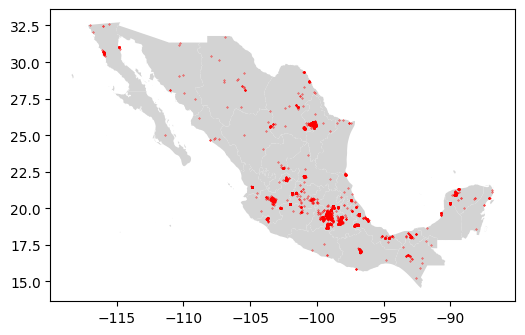

In [18]:
# plot
fig, ax = plt.subplots(figsize=(6, 6))
gdf_mex_states.plot(ax=ax, color='lightgrey')
gdf_properties_wrong_mun.plot(ax=ax, color='red', markersize=0.1)

In [19]:
# clean the properties that did not match
index_unwanted = gdf_properties_wrong_mun.index

# drop
gdf_properties = gdf_properties.drop(index_unwanted, axis=0)

# print
gdf_properties.shape

(945183, 41)

---
# Save

In [22]:
# subset
gdf_properties = gdf_properties[list(original_columns)]

# save
os.makedirs("../../data/interim", exist_ok=True)
gdf_properties.to_parquet("../../data/interim/cleaned_data_s2.parquet")

---
# Sandbox

In [ ]:
# crs
gdf_properties_wrong_mun

In [ ]:
# see 9067220712861680 property_id
gdf_properties_wrong_mun.loc[lambda x: x['property_id'] == '9067220712861680']

In [ ]:
# see 9067220712861680 property_id
gdf_properties.loc[lambda x: x['property_id'] == '9067220712861680']

In [ ]:
index_unwanted

In [ ]:
df_repeated_stats['property_id'].nunique()

In [ ]:
df_repeated_stats

In [ ]:
df_repeated_stats.query("has_flag.eq(1)")

In [ ]:
gdf_properties2['has_flag'].value_counts(dropna=False)

In [ ]:
gdf_properties2['flag_time'].value_counts(dropna=False)

In [ ]:
df_repeated_stats['flag_time'].value_counts(dropna=False)

In [ ]:
gdf_properties_flag.query('flag_time.eq(1)').shape[0]

In [ ]:
gdf_properties_flag_not_time['num_samples_repeated'].value_counts()

In [ ]:
gdf_properties_flag_not_time['property_id'].value_counts()

In [ ]:
gdf_properties_flag_not_time['n_group_sub_id'].value_counts().sort_index()

In [ ]:
gdf_properties.query("property_id == '11001221110013400'")

In [ ]:
gdf_properties_flag_not_time.query("property_id == '11001221110013400'")

In [ ]:
original_columns